In [1]:
#START OF NEW Coding 

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import mdshare
import mdtraj as md
import MDAnalysis as mda
#import nglview
import pyemma
from pyemma.util.contexts import settings
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as peplt
%pylab inline

import pyemma

pyemma.__version__

'2.5.5+9.ge9257b9.dirty'


import numpy as np
%pylab inline


import pyemma.coordinates as coor

# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:

trajfile = ["/home1/wt/c1-sim1/c1-protein.xtc", "/home1/wt/c2-sim1/c2-protein.xtc", "/home1/wt/c3-sim1/c3-protein.xtc", "/home1/wt/c4-sim1/c4-protein.xtc", "/home1/wt/c5-sim1/c5-protein.xtc", "/home1/wt/c6-sim1/c6-protein.xtc", "/home1/wt/c7-sim1/c7-protein.xtc", "/home1/wt/c8-sim1/c8-protein.xtc", "/home1/wt/c9-sim1/c9-protein.xtc", "/home1/wt/c10-sim1/c10-protein.xtc", "/home1/wt/c1-sim2/c1-protein.xtc", "/home1/wt/c2-sim2/c2-protein.xtc", "/home1/wt/c3-sim2/c3-protein.xtc", "/home1/wt/c4-sim2/c4-protein.xtc", "/home1/wt/c5-sim2/c5-protein.xtc", "/home1/wt/c6-sim2/c6-protein.xtc", "/home1/wt/c7-sim2/c7-protein.xtc", "/home1/wt/c8-sim2/c8-protein.xtc", "/home1/wt/c9-sim2/c9-protein.xtc", "/home1/wt/c10-sim2/c10-protein.xtc", "/home1/wt/c1-sim3/c1-protein.xtc", "/home1/wt/c2-sim3/c2-protein.xtc", "/home1/wt/c3-sim3/c3-protein.xtc", "/home1/wt/c4-sim3/c4-protein.xtc", "/home1/wt/c5-sim3/c5-protein.xtc", "/home1/wt/c6-sim3/c6-protein.xtc", "/home1/wt/c7-sim3/c7-protein.xtc", "/home1/wt/c8-sim3/c8-protein.xtc", "/home1/wt/c9-sim3/c9-protein.xtc", "/home1/wt/c10-sim3/c10-protein.xtc"
]
topfile = '/home1/wt/wt-protein.gro'


xtc_traj = md.load (trajfile, top='/home1/wt/wt-protein.gro')

pdb = md.load ('/home1/wt/wt-protein.gro')

In [3]:
import MDAnalysis as mda

# Load your .gro and .xtc files
universe = mda.Universe("/home1/wt/wt-protein.gro", "/home1/wt/c1-sim1/c1-protein.xtc")

# Get timestep from the first two frames
timestep = universe.trajectory[1].time - universe.trajectory[0].time
print(f"Timestep of the trajectory is: {timestep} ps")


Timestep of the trajectory is: 10.0 ps


/home/rajarshi/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/XDR.py:202: UserWarning: Cannot write lock/offset file in same location as /home1/wt/c1-sim1/c1-protein.xtc. Using slow offset calculation.
  warnings.warn(f"Cannot write lock/offset file in same location as "
/home/rajarshi/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/XDR.py:258: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/home1/wt/c1-sim1/.c1-protein.xtc_offsets.npz'
  warnings.warn(f"Couldn't save offsets because: {e}")


In [4]:
#Selecting the feature for MSM Building

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=True, cossin=True)
data = pyemma.coordinates.load(trajfile, features=feat)



inp = coor.source(trajfile, feat)
print('trajectory length = ',inp.trajectory_length)
print('number of dimension = ',inp.dimension())




Obtaining file info:   0%|                                                                 | 0/29 [00:00<?, ?i…

getting output of FeatureReader:   0%|                                                     | 0/29 [00:00<?, ?i…

Obtaining file info:   0%|                                                                 | 0/29 [00:00<?, ?i…

trajectory length =  <bound method DataSource.trajectory_length of <pyemma.coordinates.data.feature_reader.FeatureReader object at 0x7fc914d15ee0>>
number of dimension =  48


In [5]:


def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores




/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:

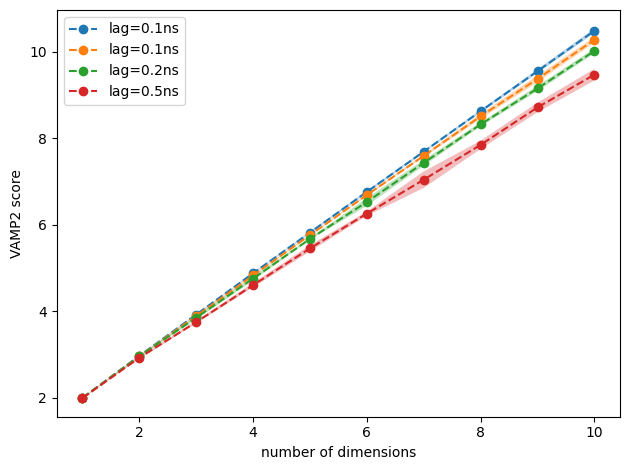

In [6]:
#Finding lag time and dimensions for tICA dimenstion reduction
#Maybe wont converge, so use intuition

lags = [5,10,20,50]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.01))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [17]:
#DOING TICA

lag=10
tica_obj = coor.tica(inp, lag=lag, dim=2, kinetic_map=False)


Y7 = [
    tica_obj.get_output()[0], 
    tica_obj.get_output()[1], 
    tica_obj.get_output()[2], 
    tica_obj.get_output()[3],
    tica_obj.get_output()[4],
    tica_obj.get_output()[5],
    tica_obj.get_output()[6],
    tica_obj.get_output()[7],
    tica_obj.get_output()[8],
    tica_obj.get_output()[9],
    tica_obj.get_output()[10],
    tica_obj.get_output()[11],
    tica_obj.get_output()[12],
    tica_obj.get_output()[13],
    tica_obj.get_output()[14],
    tica_obj.get_output()[15],
    tica_obj.get_output()[16],
    tica_obj.get_output()[17],
    tica_obj.get_output()[18],
    tica_obj.get_output()[19],
    tica_obj.get_output()[20],
    tica_obj.get_output()[21],
    tica_obj.get_output()[22],
    tica_obj.get_output()[23],
    tica_obj.get_output()[24],
    tica_obj.get_output()[25],
    tica_obj.get_output()[26],
    tica_obj.get_output()[27],
    tica_obj.get_output()[28]

    ]

Y = np.vstack(Y7)


print('Projected data shape = ', Y.shape)



/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|                                                               | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

getting output of TICA:   0%|                                                              | 0/29 [00:00<?, ?i…

Projected data shape =  (580029, 2)


Text(0.5, 0, 'time (10 ps)')

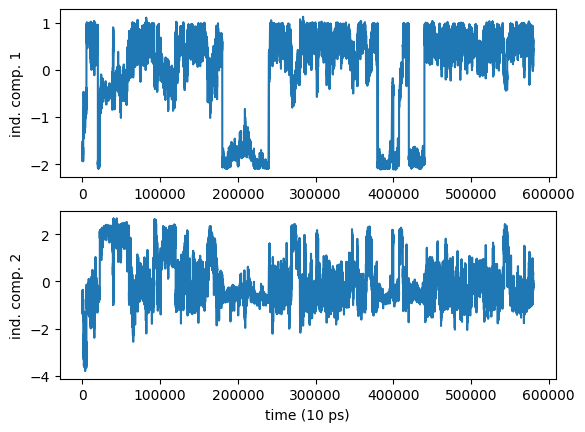

In [20]:
#PLotting TICA plots vvith time

subplot2grid((2,1),(0,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y[:,1])
ylabel('ind. comp. 2')
xlabel('time (10 ps)')

#plt.savefig('1_TICA_plot_wt.png')

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x7fc902e98eb0>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x7fc8f4fd6520>})

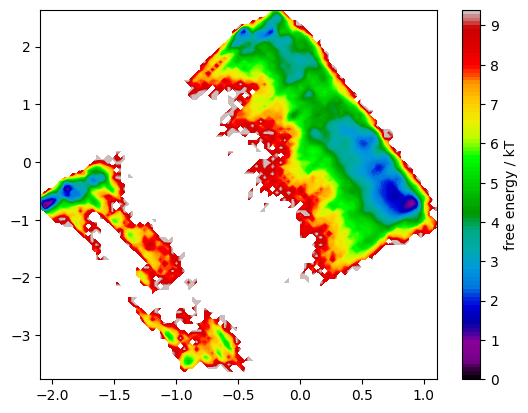

In [23]:
#Plotting the IC1 and IC2 Energy plot

pyemma.plots.plot_free_energy(*Y.T[0:2], legacy=False)

/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/

13-01-25 23:57:40 pyemma.coordinates.clustering.kmeans.KmeansClustering[50] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_Deprecatio

13-01-25 23:57:56 pyemma.coordinates.clustering.kmeans.KmeansClustering[82] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/home/rajarshi/miniconda3/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


13-01-25 23:58:01 pyemma.coordinates.clustering.kmeans.KmeansClustering[90] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/home/rajarshi/miniconda3/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


13-01-25 23:58:03 pyemma.coordinates.clustering.kmeans.KmeansClustering[94] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/home/rajarshi/miniconda3/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_Deprecatio

13-01-25 23:58:23 pyemma.coordinates.clustering.kmeans.KmeansClustering[114] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/home/rajarshi/miniconda3/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
/home/rajarshi/miniconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_Deprecatio

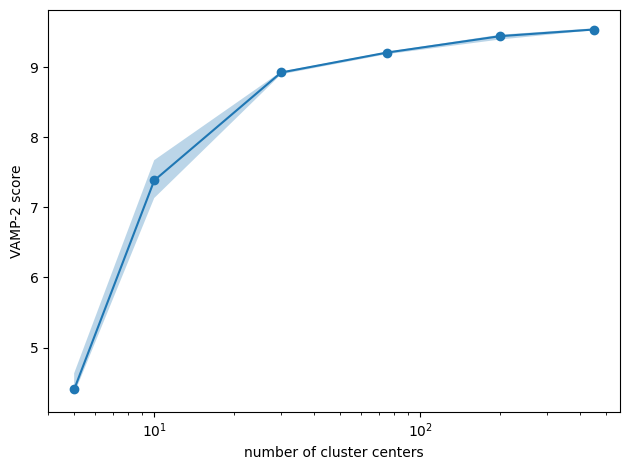

In [22]:
#Number of clustering to be decided


n_clustercenters = [5, 10, 30, 75, 200, 450]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                Y, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

In [ ]:
#CLustering Happening here



cl = coor.cluster_kmeans(data=Y, k=75, max_iter = 500)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

In [ ]:
#Clustering plots

plt.figure(figsize=(6, 4)) 
short_dist_tica_concatenated = np.concatenate(Y)
pyemma.plots.plot_free_energy(*Y.T[0:2], legacy=False)

plot(cc_x,cc_y, linewidth=0, marker='o', markerfacecolor='white',  # Fill color of the marker
    markeredgecolor='black', markeredgewidth=0.6,  # Thickness of the border
    markersize=5 ) 
plt.xlabel('IC 1')
plt.ylabel('IC 2')
plt.show()
print(short_dist_tica_concatenated)


In [ ]:
#MSM_Estimation
import pyemma.msm as msm
import pyemma.plots as mplt




In [ ]:
#Selection of lag time

lags = [1,2,5,50, 100, 150, 200 ,250]
its = pyemma.msm.its(cl.dtrajs, lags=lags, nits=10, errors='bayes')

In [ ]:
pyemma.plots.plot_implied_timescales(its, dt=0.1, units='(ns)' , marker='None');

plt.xlabel('τ (ns)')
plt.ylabel('ti (ns)')

import pyemma.msm as msm
import pyemma.plots as mplt

#mplt.plot_implied_timescales(its)

#plt.savefig('1_ITS_Plot_Nevv_double.png')


plt.savefig('1_ITS_PLOT_al.png')
#K means

In [ ]:
dtrajs_concatenated = np.concatenate(cl.dtrajs)

In [ ]:
M = msm.estimate_markov_model(dtrajs_concatenated, 1000)


In [ ]:
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

In [ ]:
#Eigen spectrum analysis

plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (ns)'); xlim(-0.5,10.5)

In [ ]:
#plt.savefig('time_scalevsindex_double.png')

plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)

In [ ]:
dtrajs_concatenated = np.concatenate(cl.dtrajs)

In [ ]:
print('hi')

M = msm.estimate_markov_model(dtrajs_concatenated, 1000)

print(len(dtrajs[0]))

In [ ]:
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

In [ ]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (ns)'); xlim(-0.5,10.5)

In [ ]:
#plt.savefig('time_scalevsindex_double.png')

plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)

In [ ]:
#Saving pdb structures

nstates = 3

M.pcca(nstates)

two_dist_msm = M
B = M.metastable_assignments
print(B)
C = []
for i in range(len(two_dist_msm.metastable_assignments)):
    if two_dist_msm.metastable_assignments[i] == 1:
        C.append(two_dist_msm.metastable_assignments[i])
print(len(C))



pcca_samples = two_dist_msm.sample_by_state(1, subset = B)

trjfile = [["/home1/wt/c1-sim1/c1-protein.xtc", "/home1/wt/c2-sim1/c2-protein.xtc", "/home1/wt/c3-sim1/c3-protein.xtc", "/home1/wt/c4-sim1/c4-protein.xtc", "/home1/wt/c5-sim1/c5-protein.xtc", "/home1/wt/c6-sim1/c6-protein.xtc", "/home1/wt/c7-sim1/c7-protein.xtc", "/home1/wt/c8-sim1/c8-protein.xtc", "/home1/wt/c9-sim1/c9-protein.xtc", "/home1/wt/c10-sim1/c10-protein.xtc", "/home1/wt/c1-sim2/c1-protein.xtc", "/home1/wt/c2-sim2/c2-protein.xtc", "/home1/wt/c3-sim2/c3-protein.xtc", "/home1/wt/c4-sim2/c4-protein.xtc", "/home1/wt/c5-sim2/c5-protein.xtc", "/home1/wt/c6-sim2/c6-protein.xtc", "/home1/wt/c7-sim2/c7-protein.xtc", "/home1/wt/c8-sim2/c8-protein.xtc", "/home1/wt/c9-sim2/c9-protein.xtc", "/home1/wt/c10-sim2/c10-protein.xtc", "/home1/wt/c1-sim3/c1-protein.xtc", "/home1/wt/c2-sim3/c2-protein.xtc", "/home1/wt/c3-sim3/c3-protein.xtc", "/home1/wt/c4-sim3/c4-protein.xtc", "/home1/wt/c5-sim3/c5-protein.xtc", "/home1/wt/c6-sim3/c6-protein.xtc", "/home1/wt/c7-sim3/c7-protein.xtc", "/home1/wt/c8-sim3/c8-protein.xtc", "/home1/wt/c9-sim3/c9-protein.xtc", "/home1/wt/c10-sim3/c10-protein.xtc"
]]


short_dist = pyemma.coordinates.source(trjfile, features=feat)
print(pcca_samples)
pyemma.coordinates.save_trajs(
    short_dist,
    pcca_samples,
    prefix = 'AL_STRUCTURE_TOR',
    fmt = 'pdb')


In [ ]:

pcca_dist = M.metastable_distributions
pcca_samples = M.sample_by_distributions(pcca_dist, 1000)
pcca_sets_6 = M.metastable_sets


#SAVING TRAJECTOREIS

inp = coor.source(trjfile, feat)
coor.save_traj(inp, pcca_samples[0], 'pcca1_AL_TOR.xtc')
coor.save_traj(inp, pcca_samples[1], 'pcca2_AL_TOR.xtc')
coor.save_traj(inp, pcca_samples[2], 'pcca3_AL_TOR.xtc')
coor.save_traj(inp, pcca_samples[3], 'pcca4_AL_TOR.xtc')
coor.save_traj(inp, pcca_samples[4], 'pcca5_AL_TOR.xtc')

##VISUALIZING

#from IPython.display import Image
#Image(filename='./data/pcca_structures.png', width=800)

In [ ]:
# Caclulating stationary probaility matrix and the mpft of transitions

for i, s in enumerate(two_dist_msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, two_dist_msm.pi[s].sum()))
    
two_dist_msm.pcca(nstates)    
two_dist_mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        two_dist_mfpt[i, j] = two_dist_msm.mfpt(
            two_dist_msm.metastable_sets[i],
            two_dist_msm.metastable_sets[j])

two_dist_inverse_mfpt = np.zeros_like(two_dist_mfpt)
two_dist_nz = two_dist_mfpt.nonzero()
two_dist_inverse_mfpt[two_dist_nz] = 1.0 / two_dist_mfpt[two_dist_nz]

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(two_dist_mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

In [ ]:
#Visualizing the macrostates formed after coarse graining

nstates = 5
M.pcca(5)
metastable_traj = M.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *Y[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [ ]:
#SEEING MICROSTATES VVITH THE PDB Structure number on energy landscape


import matplotlib.pyplot as plt
pcca_sets_6 = M.metastable_sets
pyemma.plots.plot_free_energy(*Y.T[0:2], legacy=False)


    # Highlight points corresponding to metastable state 0
metastable_indices = [i for i, state in enumerate(B) if state == 0]
metastable_x = cc_x[metastable_indices]
metastable_y = cc_y[metastable_indices]
plt.scatter(metastable_x, metastable_y, color='green',label='Metastable State 0', edgecolors ='black', s=20)

           
# Highlight points corresponding to metastable state 1
metastable_indices = [i for i, state in enumerate(B) if state == 1]
metastable_x = cc_x[metastable_indices]
metastable_y = cc_y[metastable_indices]
plt.scatter(metastable_x, metastable_y, color='red', label='Metastable State 1', edgecolors='black', s=20)

# Highlight points corresponding to metastable state 2
metastable_indices = [i for i, state in enumerate(B) if state == 2]
metastable_x = cc_x[metastable_indices]
metastable_y = cc_y[metastable_indices]
plt.scatter(metastable_x, metastable_y, color='yellow', label='Metastable State 2', edgecolors='red', s=20)


# Highlight points corresponding to metastable state 3
metastable_indices = [i for i, state in enumerate(B) if state == 3]
metastable_x = cc_x[metastable_indices]
metastable_y = cc_y[metastable_indices]
plt.scatter(metastable_x, metastable_y, color='black', label='Metastable State 3', edgecolors='red', s=20)

#Highlight points corresponding to metastable state 4
metastable_indices = [i for i, state in enumerate(B) if state == 4]
metastable_x = cc_x[metastable_indices]
metastable_y = cc_y[metastable_indices]
plt.scatter(metastable_x, metastable_y, color='red', label='Metastable State 4', edgecolors='pink', s=20)



            
            
            
            

# Highlight points corresponding to metastable state 0
metastable_indices_0 = [i for i, state in enumerate(B) if state == 0]

for i in metastable_indices_0:
    plt.text(cc_x[i], cc_y[i], f"{i}", fontsize=8, color='white')

# Highlight points corresponding to metastable state 1
metastable_indices_1 = [i for i, state in enumerate(B) if state == 1]

for i in metastable_indices_1:
    plt.text(cc_x[i], cc_y[i], f"{i}", fontsize=8, color='white')

# Highlight points corresponding to metastable state 2
metastable_indices_2 = [i for i, state in enumerate(B) if state == 2]

for i in metastable_indices_2:
    plt.text(cc_x[i], cc_y[i], f"{i}", fontsize=8, color='white')

# Highlight points corresponding to metastable state 3
metastable_indices_2 = [i for i, state in enumerate(B) if state == 3]

for i in metastable_indices_2:
    plt.text(cc_x[i], cc_y[i], f"{i}", fontsize=8, color='white')


 # Highlight points corresponding to metastable state 4
metastable_indices_2 = [i for i, state in enumerate(B) if state == 4]

for i in metastable_indices_2:
    plt.text(cc_x[i], cc_y[i], f"{i}", fontsize=8, color='white')




# Add labels, legend, and title
plt.xlabel("IC 1")
plt.ylabel("IC 2")
plt.title("Cluster Centers")
plt.legend()
plt.legend(fontsize=5)
plt.show()
